<a href="https://colab.research.google.com/github/jonathanyin12/Pokemon_GAN/blob/master/PokemonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PokémonGAN**
**A generative adversarial network that creates new Pokémon from a latent noise vector.**

Note: code available on [Google Colab](https://colab.research.google.com/drive/1x-K3smQp346dR2qa2F3vYaMfaDvtx9Mt). Training data can be found [here.](https://drive.google.com/open?id=10Wtmd6NsfhmSiws68muWYnhyGqyKWrsZ)

## **Load data**

### **Connect to Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_folder='/content/drive/My Drive/GANs/DCGAN/'

### **Unzip training dataset**

In [0]:
from zipfile import ZipFile

data_path='/content/drive/My Drive/GANs/pokemon_dataset.zip'

with ZipFile(data_path, 'r') as zipObj:
   zipObj.extractall()

### **Prepare images into NumPy array**

In [0]:
from PIL import Image
import os
from tqdm import tqdm_notebook
import numpy as np

def load_data(path, img_dim):
    images = []
    for file in tqdm_notebook(os.listdir(path)):
        img = Image.open(os.path.join(path, file))
        img = img.resize((img_dim, img_dim))
        img = np.array(img)
        img = (img-127.5)/127.5
        images.append(img)
    return np.asarray(images)

data_dir = '/content/training_dataset'
img_dim = 128
images = load_data(data_dir, img_dim)

### **Display image from dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


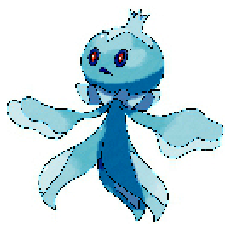

In [5]:
from matplotlib import pyplot as plt

plt.imshow(images[0])
plt.axis('off')
plt.show()

## **Model architecture**

Uses DCGAN architecture presented by Radford et. al. 2015. The paper can be found here: [https://arxiv.org/pdf/1511.06434.pdf](https://arxiv.org/pdf/1511.06434.pdf)

### **Generator network**

In [0]:
from keras.layers import Dense, Reshape, Flatten, Input, BatchNormalization, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.models import Sequential


def build_generator():
    net = Sequential()    
    net.add(Dense(16*16*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    net.add(Reshape((16,16,256)))
    net.add(Dropout(0.4))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(3, 5, padding='same'))
    net.add(Activation('tanh'))   

    net.summary()
    
    return net

### **Discriminator network**

In [0]:
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

def build_discriminator():
    net = Sequential()
    net.add(Conv2D(64, 5, strides=2, input_shape=(128, 128, 3), padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(0.4))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(0.4))
    
    net.add(Conv2D(512, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(0.4))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    net.summary()
    
    return net

### **Compile models**

Adversarial model combines both generator and discriminator


In [0]:
from keras.optimizers import Adam, RMSprop

discriminator_model = build_discriminator()
discriminator_optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8)
discriminator_model.compile(loss='binary_crossentropy', 
                            optimizer=discriminator_optimizer,
                            metrics=['accuracy'])


adversarial_model = Sequential()
generator = build_generator()
adversarial_model.add(generator)

# discriminator layers frozen so only generator layers will train
for layer in discriminator_model.layers: 
    layer.trainable = False

adversarial_model.add(discriminator_model)
adversarial_optimizer=Adam(lr=0.0001, clipvalue=1.0, decay=3e-8)
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=adversarial_optimizer,
                          metrics=['accuracy'])   

## **Training**

### **Load previous weights**

In [0]:
past_epoch=0

try: 
    discriminator_model.load_weights(root_folder+'Weights/discriminator_weights{}.h5'.format(past_epoch))
    adversarial_model.load_weights(root_folder+'Weights/adversarial_weights{}.h5'.format(past_epoch))
    print('Loading model weights')
except:
    print('No model weights found.')

### **Custom training function**

In [0]:
def train(epoch, batch_size):
    print('\nEpoch: {}'.format(epoch))
    
    np.random.shuffle(images)
    total_steps = images.shape[0] // batch_size
   
    for step in tqdm_notebook(range(total_steps)):
        # generate fake images by passing random noise into generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        images_fake = generator.predict(noise) 
        
        # combine fake and real images
        images_real = images[step * batch_size: (step + 1) * batch_size]  
        x = np.concatenate((images_fake, images_real)) 

        # create training labels
        y = np.zeros([2*batch_size, 1])
        y[batch_size:, :] = 1 
    
        # train discriminator on fake and real images 
        d_stats = discriminator_model.train_on_batch(x, y)   
        
        # train generator based on ability to fool discriminator
        noise = np.random.normal(0, 1, (batch_size*2, 100))
        a_stat = adversarial_model.train_on_batch(noise, np.ones([batch_size*2, 1])) 

        if step%100==0:
            print(step)
            print(d_stats)
            print(a_stat)

### **Function to generate training sample**

In [0]:
training_sample_path = root_folder + "Training Samples/"

try:
    print('Visual noise loaded.')
    vis_noise = np.load(root_folder+'vis_noise.npy')

except:
    print('Creating new visual noise.')
    vis_noise = np.random.normal(0, 1, (16, 100))
    np.save(root_folder+'vis_noise', vis_noise)


def genSample(path, epoch):
    generated_images = generator.predict(vis_noise)
    plt.figure(figsize=(10, 10))
    generated_images = (generated_images*0.5)+0.5
    
    for im in range(generated_images.shape[0]):
        plt.subplot(4, 4, im + 1)
        image = generated_images[im, :, :, :]
        plt.imshow(image)
        plt.axis('off')

    plot = path+'Epoch{}.png'.format(epoch)
    plt.savefig(plot)
    plt.close('all')   


### **Train model**

In [0]:
batch_size = 64

for epoch in range(1, 1001):
    genSample(training_sample_path, epoch)
    train(epoch, batch_size)

    if epoch%100==0:
        discriminator_model.save_weights(root_folder+'Weights/discriminator_weights_epoch{}.h5'.format(epoch))
        adversarial_model.save_weights(root_folder+'Weights/adversarial_weights_epoch{}.h5'.format(epoch))                             
